# Nonlinear classifiers

## Load X,y data from NPZ

Using the function added to *mylib.py* file, it's now easy to grab data and X/y vectors ready to be used for model training and tuning

In [128]:
# Run content of mylib.py file
%run mylib.py

# Load data from NPZ file
(data, X, y)=loadXy(verbose=False)

## Random Tree Classifier

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Cross Validation K-Fold dimension
CV=5

# Create RandomClassifier object with default values
rfc = RandomForestClassifier(random_state=0)

# Set grid parameters for hyperparameters tuning
grid_param={
    'n_estimators': np.arange(1, 100, step=1),
    'max_depth': [None],
}

grid_rfc=GridSearchCV(rfc, grid_param, cv=CV, refit=True, return_train_score=True, verbose=True, n_jobs=-1, iid=True)

grid_rfc.fit(X['trainX'], y['trainX'])

best_estimator=grid_rfc.best_estimator_

accuracy_rfc=best_estimator.score(X['test'], y['test'])*100

print("\n")
print("RandomForestClassifier best estimator score : {:.1f}%".format(accuracy_rfc))


Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   19.2s finished




RandomForestClassifier best estimator score : 92.2%


Let's display the best parameter we've found for n_estimator.

> Note: The sort is done in descending order on two columns, mean_test_score and std_test_score, to get the n_estimator value that fits best the mean and the standard deviation. If using only the mean as sorting column, the first line of the sort might not be the best estimator as the mean is identical for several n_estimator parameters.

In [134]:

columns=['param_n_estimators', 'param_max_depth', 'mean_test_score', 'std_test_score', 'mean_train_score']
results_df=pd.DataFrame(grid_rfc.cv_results_).sort_values(['mean_test_score', 'std_test_score'], ascending=False)[columns]

results_df.head()

,param_n_estimators,param_max_depth,mean_test_score,std_test_score,mean_train_score
44,45,None,0.923810,0.022638,0.999399
83,84,None,0.923810,0.021136,1.000000
86,87,None,0.923810,0.018769,1.000000
58,59,None,0.923810,0.017590,1.000000
95,96,None,0.921429,0.025623,1.000000


It's now time to save our estimator with the best hyperparameters found: *n_estimator=45*

In [135]:
saveModel(best_estimator, 'random-forest')

Saving model random-forest to model-random-forest.sav


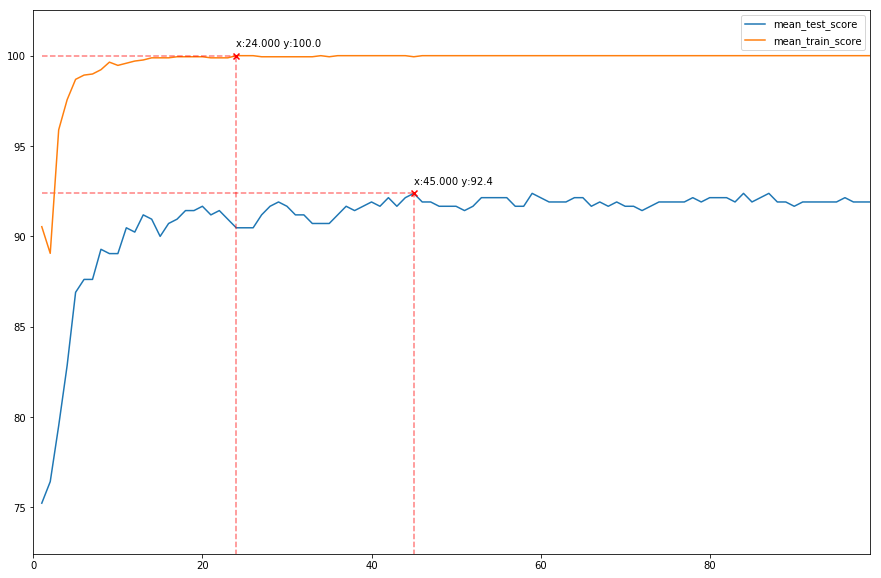

In [136]:
import matplotlib.pyplot as plt

def plotTestCurve(results_df, x_param, y_param=[], semilogx=True, xlabel='', ylabel='', title='', figsize=(15,10), std_param={}):
    """
    Function to graph data points from GridSearchCV results. Can be used to graph the mean test and train
    score of a GridSearchCV fitted object.
    Note that the graph built expects % values on the Y axis (mean_test_score, mean_train_score for example) 
    Mandatory parameters are:
        results_df: A dataframe built from GridSearchCV.cv_results_
        x_param: The column name of the results_df dataframe to be used as X axis
        y_param: An array of column to be plotted on the Y axis. Those values must be %.
    Optionnal parameters:
        semilogx: If True, the X data points are plotted using a log10 scale
        xlabel: Label of the X axis
        ylabel: Label of the Y axis
        title: Title of the graph
        figsize: Size ot the graph
        std_param: A dict with key=y_param element and value the corresponding std deviation column name.
            This parameters is used to draw the std deviation of the y_params as a filled area around the data plot
            
    The function will also determine, for each of the y_param to be plotted, which is the plot with the highest
    y_param value, and use the coordinates to draw a red cross on the plotted line, along with horizontal and
    vertical lines to the X and Y axis.
    For that purpose, the function first sort the results_df dataframe using the x_param column in ascending order.
    """
    # Order dataframe by xparam value
    temp_df=results_df.sort_values(x_param, ascending=True)

    # Define figsize
    plt.figure(figsize=figsize)

    # Store x_min, x_max, y_min and y_max values to set xlimit and ylimit of the graph
    x_min=0
    y_min=100
    x_max=0
    y_max=0
    
    # Loop for each yparam plot
    for i in y_param:
        # Find indices of  the best y value
        best_idx=temp_df[i].idxmax()

        # Get best x information
        best_x = temp_df[x_param][best_idx]
        # Get x plots
        x_values=temp_df[x_param]
        # Store x_min and x_max if needed
        if x_min>np.min(x_values):
            x_min=np.min(x_values)
        if x_max<np.max(x_values):
            x_max=np.max(x_values)



        # get best y information
        best_y=temp_df[i][best_idx]*100 # Multiply by 100 to get %
        # Get y plots
        y_values=temp_df[i]*100
        # Store y_min and y_max if needed
        if y_min>np.min(y_values):
            y_min=np.min(y_values)-y_values.std()
        if y_max<np.max(y_values):
            y_max=np.max(y_values)+y_values.std()

        if semilogx:
            plt.semilogx(x_values, y_values, label=i)
        else:
            plt.plot(x_values, y_values, label=i)

        # Draw a cross on the best_x/best_accuracy point
        plt.scatter(best_x, best_y, marker='x', c='red', zorder=10)
        # Write near of the cross the best_y/best_y value
        plt.text(best_x, best_y+0.5, 'x:{:.3f} y:{:.1f}'.format(best_x, best_y))
        plt.plot([best_x, best_x], [0, best_y], c='red', alpha=0.5, linestyle='--')
        plt.plot([np.min(x_values), best_x], [best_y, best_y], c='red', alpha=0.5, linestyle='--')
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.ylim(bottom=y_min, top=y_max+1)
    plt.xlim(left=x_min, right=x_max)
    plt.legend()
    plt.show()

plotGridSearchResults(results_df, 'param_n_estimators', ['mean_test_score', 'mean_train_score'], semilogx=False)